*This notebook was created by Sergey Tomin (sergey.tomin@desy.de) and Martin Dohlus (DESY). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). May 2018.*

## Tutorial N8. Physics process addition. Laser heater
The OCELOT Charged Particle Beam Dynamics (CPBD) module includes various physics processes like CSR, SpaceCharge, Wake3D, BeamTransform. There are other "physics processes", which do not have anything in common with physics but use the same interface (or parent class "PhysProc") e.g. SaveBeam. Using this interface, one can implement own "physics process". In this tutorial we will show how to do it on the example of the laser heater. 

We will start with the theory of the laser heater and then will show how to implement the heating process in the code. 

##### *Acknowledgment*
We wish to thank Igor Zagorodnov for fruitful discussion.

### Contents
1. [Theory of the laser heater](#theory)
    2. [Electron motion in an undulator](#electron_motion)
        - [First order approximation](#first_order)
        - [Second order approximation](#second_order)
    3. [Gaussian beam](#gaussian_beam)
    4. [Electric field amplitude of the laser beam](#electric_field)
    5. [Interaction of an electron with electromagnetic field](#interaction)
    6. [Practical formulas and laser heater parameters](#practical)
6. [Implementation of the LaserHeater class](#phys_proc) 
7. [Simulation](#simulation)
    8. [Tracking without the laser heater effect](#without)
    9. [Tracking with the laser heater effect](#with)


<a id='theory'></a>
## Theory of the laser heater 

Most of the expressions and the way to derive them were copied from the book [1]. Here we collect all parts together for educational purposes. 

1. [*Schmüser P., Dohlus M., Rossbach J., Behrens C. (2014) Undulator Radiation. In: Free-Electron Lasers in the Ultraviolet and X-Ray Regime. Springer Tracts in Modern Physics, vol 258. Springer, Cham*](https://link.springer.com/book/10.1007/978-3-319-04081-3)

<a id='electron_motion'></a>
### Electron motion in an undulator
First, we will consider electron motion in an undulator. 

<a id='first_order'></a>
#### First order approximation

The equation of motion for an electron in the magnetic field is defined by:

\begin{equation}
\gamma m_e \dot{\mathbf{v}} = - e \mathbf{v} \times \mathbf{B} 
\end{equation}

which results into two coupled equations:

\begin{equation}
\ddot{x} = \frac{e}{\gamma m_e} B_y \dot{z}, \qquad \ddot{z} = -\frac{e}{\gamma m_e} B_y \dot{x}
\end{equation}
$$\qquad$$
In the first order approximation $v_z = \dot{z} \approx v = \beta c = const$, $v_x << v_z$ and $\ddot{z} \approx 0$ and taking into account the undulator magnetic field $B_y = -B_0\sin(k_y z)$ we get:

\begin{equation}
x(t) \approx \frac{e B_0}{\gamma m_e \beta c k_u^2}\sin(k_u \beta c t), \qquad z(t) \approx \beta c t
\end{equation}

The electron travels on the sine-like trajectory 

\begin{equation}
x(z) = \frac {K} {\beta \gamma k_u}\sin(k_u z),
\end{equation}

where $K = \frac{eB_0}{m_e c k_u}$ and transverse velocity is 

\begin{equation}
v_x(t) = \frac {K c}{\gamma} \cos(k_u \beta c t) \qquad or \qquad v_x(z) = \frac {K c}{\gamma} \cos(k_u z)
\end{equation}


<a id='second_order'></a>
#### Second order approximation

The longitudinal component of the velocity is not constant in the undulator due to transverse motion: 

\begin{equation}
v_z = \sqrt{v^2 - v_x^2} = \sqrt{c^2(1 - 1/\gamma^2) - v_x^2} \approx c\left(1 - \frac{1}{2\gamma^2} (1 + \gamma^2 v_x^2 / c^2) \right)
\end{equation}
$$\quad$$
Inserting for $v_x = \dot{x}(t)$ and using the trigonometric identity $\cos^2 \alpha = (1 + \cos 2 \alpha)/2$

\begin{equation}
v_z(t) = \left(1 - \frac{1}{2 \gamma^2}\left(1 + \frac{K^2}{2}\right) \right)c - \frac{c K^2}{4 \gamma^2}\cos(2 \omega_u t)
\end{equation}

with $\omega_u = \overline \beta c k_u \approx c k_u$. The average longitudinal spead is:

\begin{equation}
\boxed{\overline v_z = \left(1 - \frac{1}{2 \gamma^2}\left(1 + \frac{K^2}{2}\right) \right)c \equiv \overline \beta c}
\end{equation}

The particle trajectory in the second order is described by:

\begin{equation}
x(t) = \frac{K}{\gamma k_u} \sin(\omega_u t), \qquad  \boxed{z(t) = \overline{v_z}t - \frac{K^2}{8\gamma^2 k_u}\sin(2\omega_u t)}
\end{equation}

<a id='gaussian_beam'></a>
### Gaussian beam

The light wave co-propagating with the relativistic electron beam is described by an electromagnetic wave:

\begin{equation}
\mathbf{E}(x,y,z, t) = Re \{ E(x,y,z) e^{j (k z - \omega t)} \}
\end{equation}

where

\begin{equation}
E(x, y, z) = E_0 \frac{ e^{-\frac{1}{2} \frac{x^2}{\sigma_x^2 - j z/k} } } {\sqrt{1-j z/(k \sigma_x^2)}}
\frac{ e^{-\frac{1}{2} \frac{y^2}{\sigma_y^2 - j z/k} } } {\sqrt{1-j z/(k \sigma_y^2)}}
\end{equation}
$$\quad$$
Introducing [Rayleigh length](https://en.wikipedia.org/wiki/Rayleigh_length) for $x$ and $y$ plane:

\begin{equation}
\mathcal{z_{Rx}} = k \sigma_x^2 = \frac{2 \pi \sigma_x^2}{\lambda} = \frac {\pi w_x^2}{\lambda}, \qquad 
\mathcal{z_{Ry}} = k \sigma_y^2 = \frac{2 \pi \sigma_y^2}{\lambda} = \frac {\pi w_y^2}{\lambda}
\end{equation}

we can write:

\begin{equation}
E(x, y, z) = E_0 \frac{ e^{-\frac{x^2}{w_x^2 - j 2 z/k} } } {\sqrt{1-j z/\mathcal{z_{Rx}}} }
\frac{ e^{-\frac{y^2}{w_y^2 - j 2 z/k} } } {\sqrt{1-j z/\mathcal{z_{Ry}}}}
\end{equation}

For a round beam and $z = 0$:

\begin{equation}
E(x,y,0) = E_0 e^{- \frac{r^2}{w^2}}
\end{equation}
where $w$ is the waist size.

<a id='electric_field'></a>
### Electric field amplitude of the laser beam
Let's find the electric field amplitude $E_0$ of the laser beam. 


Radiation power flow:
\begin{equation}
P(z,t) = \int_{S_{\bot}} \langle \mathbf{S}\rangle ds
\end{equation}

where $\langle ... \rangle$ means averaging in time, $\mathbf{S} = \mathbf{E} \times \mathbf{H}$ - the Poynting vector.

For the plane wave: 

\begin{equation}
 \langle \mathbf{S}\rangle = \frac{1}{2 Z_0}|E(x,y,z)|^2
\end{equation}
with $Z_0 \approx 376.73$ the impedance of free space.
Now we consider the round beam at $z=0$ with the waist radius $w$

\begin{equation}
\overline P(0) = \frac{1}{2 Z_0} \int |E(x,y,0)|^2 dx dy = \frac{E_0^2}{2 Z_0}\int e^{-2\frac{r^2}{w^2}}2\pi r dr = \frac{\pi E_0^2 w^2}{4 Z_0}
\end{equation}

So, the electric field amplitude is
\begin{equation}
 E_0 = \sqrt{\frac{4 Z_0 \overline P(0) }{\pi w^2}}
\end{equation}

<a id='interaction'></a>
### Interaction of an electron with electromagnetic field

The energy transfer between the light wave and an electron is described by the equation: 

\begin{equation}
W = e \int {\mathbf{E}(x,y,z,t) \cdot \mathbf{v} dt}
\end{equation}
Averaging over time $\langle \mathbf{E} \mathbf{v}\rangle$ we can write an electron energy changes $\Delta E$ after passing through an undulator with length $L_u$:
\begin{equation}
\Delta E = e \frac{L_u}{\overline{v_z}}\langle \mathbf{E} \mathbf{v}\rangle
\end{equation}

<a id='begining'></a>
Now consider only the term $\langle \mathbf{E} \mathbf{v}\rangle$:
\begin{equation}
\begin{split}
\langle v_x(t) E_x(x,y, & z, t)\rangle =  
\Big\langle Re  \{ E(x,y,z) e^{j (k z(t) - \omega t + \phi_0)} \frac {K c}{\gamma} \cos(k_u z(t)) \} \Big\rangle = 
\\
 &\frac {K c}{\gamma} Re  \left\{ E(x,y,z)\Big\langle  e^{j (k z(t) - \omega t )}  \cos(k_u z(t)) \Big\rangle \right\}
\end{split}
\end{equation}
Please note, we chose $\phi_0 = 0$ in exponential to simplify the notation, the phase accounts
for the fact that the light wave will in general be phase-shifted against the sinusoidal
trajectory of an arbitrary electron because the bunch is far longer than the light
wavelength. This phase will be reintroduced in the last step.

Remembering from section [Electron motion in undulator](#Electron motion) $z(t) = \overline{v_z}t - \frac{K^2}{8\gamma^2 k_u}\sin(2\omega_u t)$.

\begin{equation}
\Big\langle  e^{j (k z(t) - \omega t)}  \cos(k_u z(t)) \Big\rangle \approx \Big\langle  e^{j \left( k \overline v_z t - \omega t - \frac{k K^2}{8\gamma^2 k_u}\sin(2\omega_u t)\right)}  \cos(k_u \overline v_z t) \Big\rangle
\end{equation}

Introducing new variable: 

\begin{equation}
Y = \frac{k K^2}{8\gamma^2 k_u} = \frac{K^2}{4 + 2 K^2};
\end{equation}

and taking into account that: 

\begin{equation}
\cos(k_u \overline v_z t) = \frac{e^{j k_u \overline v_z t } + e^{-j k_u \overline v_z  t}}{2}
\end{equation}

we can write
\begin{equation}
\begin{split}
 \Big\langle  e^{j \left( k \overline v_z t - \omega t - \frac{k K^2}{8\gamma^2 k_u}\sin(2 k_u \overline v_z  t)\right)} & \cos(k_u \overline v_z t) \Big\rangle = 
\Big\langle  e^{j(k \overline v_z  - \omega) t} e^{j \left( - Y\sin(2 k_u \overline v_z t)\right)}  \frac{e^{j k_u \overline v_z t } + e^{-j k_u \overline v_z  t}}{2} \Big\rangle = 
\\
 &\Big\langle  e^{j((k + k_u)\overline v_z - \omega) t} e^{j \left( - Y\sin(2k_u \overline v_z t)\right)}  \frac{1 + e^{-2 j k_u \overline v_z t }}{2} \Big\rangle
\end{split}
\end{equation}

Rewriting this expression using $\theta = 2\omega_u t = 2 \overline v_z k_u t$, we obtain
<a id='problem'></a>
\begin{equation}
\Big \langle  e^{j((k + k_u)\overline v_z - \omega) t} \frac{e^{-j\theta} + 1}{2} e^{-j Y \sin\theta}\Big\rangle
\end{equation}


<br>
<div style="background-color:rgba(0, 150, 0, 0.0470588);">
<p> <b>Discussion</b></p>

<p>The [equation](#problem) above I calculated in two ways (option 1 and option 2). </p>

<p><b>Option 1</b></p>
<p>The average velocity is </p>
\begin{equation}
\overline v_z = \left(1 - \frac{1}{2 \gamma^2}\left(1 + \frac{K^2}{2}\right) \right)c
\end{equation}
<p>If we consider resonance condition only for the first harmonic $n = 1$:</p>

\begin{equation}
\lambda = \frac{\lambda_u}{2 \gamma^2}\left(1 + \frac{K^2}{2}\right)
\end{equation}

<p>then</p>

\begin{equation}
\overline v_z = \left(1 - \frac{\lambda}{\lambda_u}\right) c
\end{equation}

<p>Inserting it into the argument of the fist exponential and neglecting a term of the second order of smallness we get:</p>
\begin{equation}
(k + k_u)\overline v_z - \omega = (k + k_u)\left(1 - \frac{\lambda}{\lambda_u}\right)c - k c = 0
\end{equation}

<p>and</p>
\begin{equation}
\Big \langle  e^{j((k + k_u)\overline v_z - \omega) t} \frac{e^{-j\theta} + 1}{2} e^{-j Y \sin\theta}\Big\rangle = \Big \langle \frac{e^{-j\theta} + 1}{2} e^{-j Y \sin\theta}\Big\rangle
\end{equation}

<p>Taking into account [the standard integral representation of the Bessel function for integer orders $n$](https://en.wikipedia.org/wiki/Bessel_function)</p>

\begin{equation}
J_n(x) = \frac{1}{\pi}\int_0^\pi \cos(n\theta - x \sin\theta)d\theta = \frac{1}{2\pi}\int_{-\pi}^\pi e^{-j n\theta  + j x \sin\theta}d\theta 
\end{equation}
<p>and the Bessel function property</p>
\begin{equation}
J_n(-x) = J_{-n}(x) = (-1)^n J_n(x)
\end{equation}

<p>we finaly get</p>

\begin{equation}
\Big \langle \frac{e^{-j\theta} + 1}{2} e^{-j Y \sin\theta}\Big\rangle = \frac{J_{1}(-Y) + J_0(-Y)}{2} = \frac{J_{0}(Y) - J_1(Y)}{2}
\end{equation}

<p><b>Option 2</b></p>
<p>Expand the last exponential of the last [equation](#problem) from he previous section into a Fourier-Bessel series:</p>

\begin{equation}
e^{jY \sin \theta} = \sum_{n=-\infty}^{\infty} J_n(Y)e^{j n \theta}
\end{equation}

\begin{equation}
\begin{split}
\Big \langle   e^{j((k + k_u) \overline v_z - \omega) t} & \frac{e^{-j\theta} + 1}{2} e^{-j Y \sin\theta}\Big\rangle = \Big \langle  e^{j((k + k_u)\overline v_z - \omega) t} \frac{e^{-j\theta} + 1}{2} \sum_{n=-\infty}^{\infty} J_n(-Y)e^{j n \theta}\Big\rangle = 
\\
 \Big \langle & e^{j((k + k_u)\overline v_z - \omega) t} \frac{1}{2}\Big\{\sum_{n'=-\infty}^{\infty} J_{n'}(-Y)e^{j (n' - 1) \theta} + \sum_{n=-\infty}^{\infty} J_n(-Y)e^{j n \theta}\Big\} \Big\rangle
\end{split}
\end{equation}

<p>Making replacement $n' = n+1$:</p>

\begin{equation}
\Big \langle  e^{j((k + k_u)\overline v_z - \omega) t} \frac{1}{2}\sum_{n=-\infty}^{\infty} \Big\{J_{n+1}(-Y) + J_n(-Y)\Big\} e^{j n \theta}  \Big\rangle
\end{equation}
<p>and remembering that $\theta = 2 \overline v_z k_u t$</p>

\begin{equation}
\Big \langle  \frac{1}{2}\sum_{n=-\infty}^{\infty} \Big\{J_{n+1}(-Y) + J_n(-Y)\Big\} e^{j((k + (2n + 1)k_u)\overline v_z - \omega) t}  \Big\rangle
\end{equation}

<p>If we ensure fulfillment of the resonance condition only for the first harmonic as we did in the "Option 1" (in that case $n=0$) the only one term of the sum will survive  the only one term of the sum will survive. Indeed, for the $n=0$ argument of the exponential will be constant but for other harmonic numbers it will oscillate and give in average 0. So our final expression:</p>

\begin{equation}
\boxed{\Big \langle  e^{j((k + k_u)\overline v_z - \omega) t} \frac{e^{-j\theta} + 1}{2} e^{-j Y \sin\theta}\Big\rangle = \frac{J_{0}(Y) - J_1(Y)}{2}}
\end{equation}
</div>

#### Continuation
Collect all together, we can write the term $\langle E v\rangle$
\begin{equation}
\langle E v\rangle = \frac {K c}{\gamma} Re  \left\{ E(x,y,z)\right\}\frac{J_{0}(Y) - J_{1}(Y)}{2}
\end{equation}
$$\quad$$
Finally, remembering derivation of the electric field amplitude $E_0 = \sqrt{\frac{4 Z_0 \overline P(0) }{\pi w^2}}$, we can write expression for amplitude of energy modulation on axis ($x=y=0$)

\begin{equation}
\begin{split}
&d \mathscr E = e \frac{L_u}{\overline{v_z}}\langle \mathbf{E} \mathbf{v}\rangle = 
e \frac{L_u}{\overline{v_z}} \frac {\widetilde K c}{2\gamma} Re \left\{ E(x,y,z)\right\} = 
\\
& e \frac{L_u \widetilde K}{2 \overline{\beta} \gamma} Re  \left\{ E(0,0,0)\right\} =
e \frac{L_u \widetilde K}{\overline{\beta}\gamma} \sqrt{\frac{Z_0 \overline P(0) }{\pi w^2}}
\end{split}
\end{equation}
where $\widetilde K = K\cdot(J_{0}(Y) - J_{1}(Y))$

With $P_0 = \frac{4\pi}{Z_0}\left( \frac{m c^2}{e}\right)^2 = 8.7\, GW$ and in *eV* units:

\begin{equation}
d \mathscr E [eV] = 
2\frac{(mc^2)^2 L_u \widetilde K}{\overline{\beta} E_{beam}[eV] w} \sqrt{\frac{\overline P(0) }{P_0}}
\end{equation}

Position and phase dependent energy modulation <a id='practical formula'></a>:
\begin{equation}
\Delta E(x,y,\phi) = d \mathscr E e^{- \frac{x^2 + y^2}{4 \sigma_l^2}}\cos \phi_0
\end{equation}
where $\phi_0 = \frac{2\pi}{\lambda_{ph}}z_i$ is phase shift of the light wave against the sinusoidal trajectory of an arbitrary electron (with longitudinal coordinate $z_i$) what we chose $0$ at the [at the beginning of this journey](#begining). 

Transverse particle distribution:
\begin{equation}
P(x,y) = \frac{1}{2\pi \sigma_x \sigma_y} e^{- \frac{(x -\overline{x})^2}{2 \sigma_x^2}
- \frac{(y -\overline{y})^2}{2 \sigma_y^2}}
\end{equation}

RMS energy spread:
\begin{equation}
\mathscr E_{rms} = R d \mathscr E = \sqrt{\int \frac{d\phi}{2\pi}dx dy\times P(x,y)(\Delta E(x,y,\phi))^2} 
\end{equation}
where $R$ - shape factor (particle-photon matching), for instance for round beam no offset $R = \frac{1}{\sqrt{2 + 2(\sigma_p/\sigma_I)^2}}$

<a id='practical'></a>
### Practical formulas and the laser heater parameters

To simulate the laser heater process we need to calculate $d \mathscr E$ and then using the expression for the [energy modulation](#practical formula) we can calculate the energy spread increasing. In that case, the shape factor will be automatically taking into account.  

### The laser power estimation. 
Suppose we want to have energy spread $\mathscr E_{rms} = R d \mathscr E = 12.5\, keV$. So we can estimate the laser beam power which is needed for that. We just need to invert the expression that we got before with minor modifications:
\begin{equation}
d \mathscr E [eV] = 
2\frac{(mc^2)^2 L_u \widetilde K}{\overline{\beta} E_{beam}[eV] w} \sqrt{\frac{\overline P(0) }{P_0}}
\end{equation}
The laser power is:
\begin{equation}
\overline P(0) = \left( \frac{\mathscr E_{rms} E \overline{\beta}}{2 (mc^2)^2} \frac{w }{R L_u \widetilde K }\right)^2 P_0
\end{equation}

And finally, using expression for [position and phase dependent energy modulation](#practical formula), we can write the [energy kick](#energy_kick) in the OCELOT coordinates for $i$-particle passing $dz$ of the laser heater undulator with the particle coordinates $x, y$ - transverse coordinates,  $\{\tau = cdt;\; \delta = \frac{\Delta E}{p_0 c}\}$ - longitudinal coordinates:
<a id='energy_kick'></a>
\begin{equation}
\boxed{\delta_i = \delta_i + \frac{d \mathscr E}{p_0 c} e^{-\frac{(x_i - \overline x)^2}{4 \sigma_x^2}-\frac{(y_i - \overline y)^2}{4 \sigma_y^2}} \cos\left(\frac{2\pi}{\lambda_{ph}}\tau_i\right)\frac{dz}{L_u}}
\end{equation}
with $\overline x, \overline y$ are laser beam misalignment, and $\sigma_x, \sigma_y$ are laser beam transversal sizes. 



### Playing with numbers

The laser power is:
\begin{equation}
\overline P(0) = \left( \frac{\mathscr E_{rms} \gamma \overline{\beta}}{2 (mc^2)} \frac{w }{R L_u \widetilde K }\right)^2 P_0
\end{equation}
where $\widetilde K = K\cdot(J_{0}(Y) - J_{1}(Y))$, $Y = \frac{K^2}{4 + 2 K^2}$

$$
K = \sqrt{2\frac{\lambda}{\lambda_u}2\gamma^2 - 2}
$$
$\gamma>> 1$
$$
K = 2 \gamma \sqrt{\frac{\lambda}{\lambda_u}}
$$
Substitute 
\begin{equation}
\overline P(0) = \left( \frac{\mathscr E_{rms} \gamma \overline{\beta}}{2 (mc^2)} \frac{w }{R L_u 2 \gamma \sqrt{\frac{\lambda}{\lambda_u}}\cdot(J_{0}(Y) - J_{1}(Y)) }\right)^2 P_0
\end{equation}

\begin{equation}
\overline P(0) = \frac{\lambda_u}{\lambda} \left( \frac{\mathscr E_{rms}  \overline{\beta}}{4 (mc^2)} \frac{w }{R L_u  (J_{0}(Y) - J_{1}(Y)) }\right)^2 P_0
\end{equation}

Assuming that optimal modulator length is equal $L_u = 2 \cdot \mathcal{z_{R}} = 2 \frac{\pi w^2}{\lambda}$

\begin{equation}
\overline P(0) = \frac{\lambda_u \lambda}{1} \left( \frac{\mathscr E_{rms}  \overline{\beta}}{8 \pi (mc^2)} \frac{1 }{R w (J_{0}(Y) - J_{1}(Y)) }\right)^2 P_0
\end{equation}

the waist size
$$
w = 2 A_x + 2 \sigma_{x} 
$$

amplitude of wiggling
$$
A_x = \frac{K}{\gamma k_u} = \frac{K \lambda_u}{2 \pi \gamma } = \frac{\sqrt{\lambda \lambda_u}}{ \pi  }
$$

In [2]:
import numpy as np
from scipy.special import jv
from ocelot import *



def K2field(K, lu = 0.04):
    field = K*m_e_eV*2.*pi/(lu*speed_of_light)
    return field


# RMS energy modulation
Erms = 4e6 # eV
# electron beam energy
Eb = 2.4e9 # eV 
#Eb = 17.5e9 # eV 
# wavelength 
l_ph = 800e-9

mc2 = 0.511e6
gamma = Eb/mc2


print("gamma = ", gamma)
# undulator period length
lperiod = 0.2 # m
print("lperiod = ", lperiod)
K = 2*gamma * np.sqrt(l_ph/lperiod)

print("K estimated = ", K)
print("B estimated = ", K2field(K, lu=lperiod))
ku = 2*np.pi/lperiod
# beam size
sigma_x = 50e-6 # m
# Undulator length


# Undulator parameter
#Ku = 18.8
Ku = K
# Impedance of free space
Z0 = 376.73 # Ohm
# shape factor - ideal matching 
R = 0.5
P0 = 8.7e9 # GW
Y = Ku**2/(4+2*Ku**2)
# amplitude of beam oscilation in modulator
Ax = Ku/(gamma * ku)
print("amplitude of oscilation", Ax*1e6, " um")
# the waist radius
w = 2*sigma_x + 2 * Ax
print("waist = ", w * 1e6, " um")

# Rayleigh length
Zr = np.pi*w**2/l_ph
Lu = 2 * Zr# m
print("Zr = ", Zr, " m")

# Laser power to obtain Erms energy spread with shape factor R
P = (Erms*Eb*w/(2*mc2**2*R*Lu*Ku*(-jv(1,Y) + jv(0, Y))))**2*P0
print("Laser power =", P*1e-9, "GW")

initializing ocelot...
gamma =  4696.673189823875
lperiod =  0.2
K estimated =  18.7866927592955
B estimated =  1.0060033803412982
amplitude of oscilation 127.32395447351627  um
waist =  354.64790894703253  um
Zr =  0.49391781711690497  m
Laser power = 8.810302238315355 GW


#### Parameters of the European XFEL LH:

In [3]:
import numpy as np
from scipy.special import jv

# RMS energy spread
Erms = 20e3 # eV
# electron beam energy
Eb = 130e6 # eV 
mc2 = 0.511e6
# undulator period length
lperiod = 0.074 # m
# beam size
sigma_I = 300e-6 # m
# Undulator length
Lu = 0.666 # m
# Undulator parameter
Ku = 1.294
# Impedance of free space
Z0 = 376.73 # Ohm
# shape factor - ideal matching 
R = 0.5
P0 = 8.7e9 # GW
Y = Ku**2/(4+2*Ku**2)
# the waist radius
w = 2*sigma_I

# Laser power to obtain Erms energy spread with shape factor R
P = (Erms*Eb*w/(2*mc2**2*R*Lu*Ku*(-jv(1,Y) + jv(0, Y))))**2*P0
print("Laser power =", P, "W")

Laser power = 547479.6570391625 W


<a id='phys_proc'></a>
## Implementation of the LaserHeater class

To create class LaserHeater we use parent class PhysProc that includes two standard methods: *prepare(self, MagneticLattice)* and *apply(self, ParticleArray, dz)*.

To implement the energy kick from the laser heater we just need redefine method *apply(self, ParticleArray, dz)* 

But first, we import main OCELOT modules and functions and class PhysProc will be imported as well. 


In [4]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

# this python library provides generic shallow (copy) 
# and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# import injector lattice
from injector_lattice import *
# import from Ocelot main modules and functions 
# including parent class PhysProc
from ocelot import *

class LaserHeater(PhysProc):
    def __init__(self, step=1):
        PhysProc.__init__(self, step=1)
        # amplitude of energy modulation on axis 
        self.dE = 12500e-9 # GeV
        self.Ku = 1.294 # undulator parameter
        self.Lu = 0.8 # [m] - undulator length
        self.lperiod = 0.074 # [m] - undulator period length
        self.sigma_l = 300e-6 # [m]
        self.sigma_x = self.sigma_l
        self.sigma_y = self.sigma_l
        self.x_mean = 0
        self.y_mean = 0
        
    def apply(self, p_array, dz):
        gamma = p_array.E/m_e_GeV
        lbda_ph = self.lperiod/(2*gamma**2)*(1+self.Ku**2/2)
        k_ph = 2*np.pi/lbda_ph
        pc = np.sqrt(p_array.E**2 - m_e_GeV**2)
        
        A = self.dE/(pc)*dz/self.Lu
        dx = p_array.x()[:] - self.x_mean
        dy = p_array.y()[:] - self.y_mean
        p_array.p()[:] += A*np.cos(k_ph*p_array.tau()[:])*np.exp(
                    -0.25*dx**2/self.sigma_x**2
                    -0.25*dy**2/self.sigma_y**2)


<a id='simulation'></a>
## Simulation
As the first step, we will import injector lattice and calculate linear optics. All steps were explained in the [Tutorial N2 "Tracking"](http://nbviewer.jupyter.org/github/ocelot-collab/ocelot/blob/master/demos/ipython_tutorials/2_tracking.ipynb).

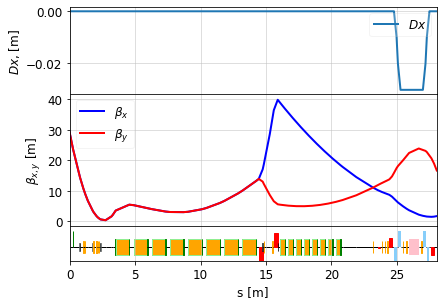

In [5]:
lat = MagneticLattice(cell, stop=EOD_51_I1)

# initialization of Twiss object
tws0 = Twiss()
# defining initial twiss parameters
tws0.beta_x = 29.171
tws0.beta_y = 29.171
tws0.alpha_x = 10.955
tws0.alpha_y = 10.955
# defining initial electron energy in GeV
tws0.E = 0.005 
# calculate optical functions with initial twiss parameters
tws = twiss(lat, tws0, nPoints=None)
# ploting twiss paramentrs.
plot_opt_func(lat, tws, top_plot=["Dx"], fig_name="i1", legend=False)
plt.show()

Laser heater undulator is shown as a pink block, blue blocks are dipoles of LH chicane
<a id='without'></a>
### Tracking without laser heater effect

In [6]:
p_array_init = load_particle_array("sc_beam.npz")
p_array = deepcopy(p_array_init)

navi = Navigator(lat)
navi.unit_step = 0.1
tws_track, p_array = track(lat, p_array, navi)

z = 28.044004999924 / 28.04400499992401 : applied: d: 

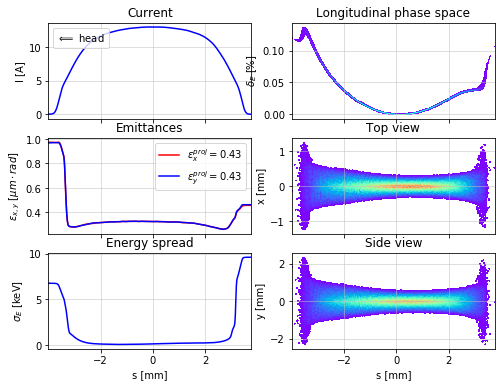

In [7]:
show_e_beam(p_array, figsize=(8,6))

<a id='with'></a>
### Tracking with Laser heater effect

z = 28.044004999924 / 28.04400499992401 : applied: d: LaserHeater

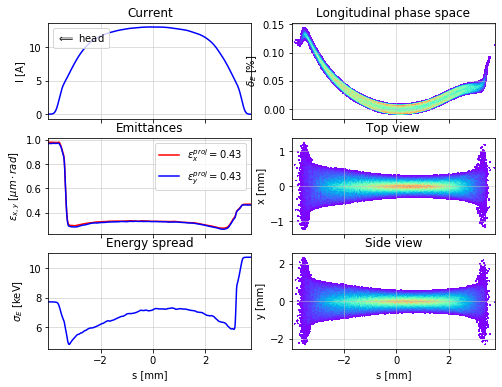

In [8]:
p_array = deepcopy(p_array_init)

navi = Navigator(lat)
navi.unit_step = 0.1
lh = LaserHeater()
lh.sigma_l = 0.0
navi.add_physics_proc(lh, und_start, und_stop)

tws_track, p_array = track(lat, p_array, navi)
show_e_beam(p_array, figsize=(8,6))